<a href="https://colab.research.google.com/github/Howuhh/dul_2021/blob/hw11/Homework/hw11/Homework11_selfsupervised2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 380, done.
remote: Counting objects: 100% (217/217), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 380 (delta 122), reused 96 (delta 66), pack-reused 163
Receiving objects: 100% (380/380), 55.90 MiB | 35.71 MiB/s, done.
Resolving deltas: 100% (179/179), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=27628 sha256=ed4a27114589c962b2a577e2b95dff51b63bc1e5157fe2cb6ac71429a4089c9e
  Stored in directory: /tmp/pip-ephem-wheel-cache-4_3pzvy7/wheels/55/59/29/0fb1c6356521

In [3]:
from dul_2021.utils.hw11_utils import *

# Question 1. BYOL

Here we will implement [BYOL](https://arxiv.org/abs/2006.07733).

* You can combine view, representation, and projection into one network. You can use same architechure as in practice. 

* Use BatchNorm

* As predictor use few linear layers

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* τ = 0.99 (target update coefficient)
* lr = 1e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [5]:
from torch.nn.modules.batchnorm import BatchNorm2d
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm, trange

from copy import deepcopy

device = "cuda" if torch.cuda.is_available() else "cpu"

class Network(nn.Module):
    def __init__(self, input_dim=1, out_dim=128, hidden_dim=128, cnn_out_dim=4 * 6 * 6):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_dim, 16, 5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 4, 1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Flatten(1)
        )
        self.linear = nn.Sequential(
            nn.Linear(cnn_out_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim)   
        )

    def forward(self, x):
        out = self.conv(x)
        out = self.linear(out)
        return out


class BYOL(nn.Module):
    def __init__(self, latent_dim=128, tau=0.01) -> None:
        super().__init__()
        self.online_net = Network(1, latent_dim)
        with torch.no_grad():
            self.target_net = deepcopy(self.online_net)
        
        self.predictor = nn.Sequential(
            nn.Linear(latent_dim, 128), 
            nn.ReLU(), 
            nn.Linear(128, 128),
            nn.ReLU(), 
            nn.Linear(128, latent_dim)
        )
        self.transforms = transforms.Compose(
            [
                transforms.RandomResizedCrop(24),
                transforms.RandomHorizontalFlip(),
                transforms.GaussianBlur(9),
                transforms.Normalize(0.5, 0.5),
            ]
        )
        self.tau = tau

    @torch.no_grad()
    def soft_update(self, target, source):
        for tp, sp in zip(target.parameters(), source.parameters()):
            tp.data.copy_((1 - self.tau) * tp.data + self.tau * sp.data)

    def __loss(self, batch):
        batch_online = self.transforms(batch)
        batch_target = self.transforms(batch)

        def _mse(v1, v2):
            z_predictor = F.normalize(self.predictor(self.online_net(v1)), dim=1)
            z_target = F.normalize(self.target_net(v2), dim=1)

            return F.mse_loss(z_predictor, z_target)

        loss = _mse(batch_online, batch_target) + _mse(batch_target, batch_online)

        return loss

    def fit(self, train_dataloader, epochs=10, lr=1e-4):
        optim = Adam(list(self.online_net.parameters()) + list(self.predictor.parameters()), lr=lr)

        losses = []
        for _ in trange(epochs, desc="Training"):
            for batch in tqdm(train_dataloader, desc="Epoch", leave=False):
                batch = batch[0].to(device)

                loss = self.__loss(batch)

                optim.zero_grad()
                loss.backward()
                optim.step()

                self.soft_update(self.online_net, self.target_net)

                losses.append(loss.detach().cpu().numpy())

        return np.array(losses)

    @torch.no_grad()
    def encode(self, x):
        self.online_net.eval()
        x = transforms.Resize(24)(x).to(device)
        x = self.online_net(x)
        self.online_net.train()
        return x


In [ ]:
def q1(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True, pin_memory=True)
    model = BYOL().to(device)
    
    losses = model.fit(train_dataloader, epochs=1, lr=1e-4)
    
    return losses, model.encode

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/235 [00:00<?, ?it/s]

mean classification accuracy=0.7442


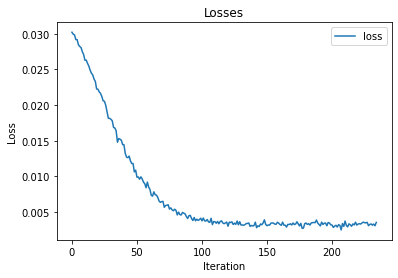

In [ ]:
q1_results(q1, True)

# Question 2. Barlow Twins

Here we will implement [barlow twins](https://arxiv.org/abs/2103.03230).

* You can use same architechure as in practice. 

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* λ = 0.01 
* lr = 5e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [11]:
def off_diagonal(matrix):
    N, M = matrix.shape
    assert N == M, "only for square matrices"
    mask = torch.eye(N, dtype=bool, device=matrix.device)
    return matrix.masked_select(~mask).reshape(N, N - 1)

class BarlowTwins(nn.Module):
    def __init__(self, latent_dim=128, lambd=1e-2):
        super().__init__()

        self.latent_dim = latent_dim
        self.lambd = lambd
        self.model = Network(3, latent_dim, cnn_out_dim=4 * 7 * 7)

        self.transforms = transforms.Compose(
            [
                transforms.RandomResizedCrop(28),
                transforms.RandomHorizontalFlip(),
                transforms.GaussianBlur(9),
                transforms.RandomApply([transforms.ColorJitter(0.5, 0.5, 0.5, 0.1)], p=0.8),
                transforms.RandomGrayscale(0.2),
                transforms.Normalize(0.5, 0.5),
            ]
        )

    def forward(self, x):
        return self.model(x)

    def covariance_matrix(self, z1, z2):
        num = z1.T @ z2
        den = torch.sqrt((z1 ** 2).sum(0)) * torch.sqrt((z2 ** 2).sum(0)).reshape(-1, 1)

        return num / den # / z1.shape[0]

    def _loss(self, batch):
        t1, t2 = self.transforms(batch), self.transforms(batch)
        z1, z2 = self.forward(t1), self.forward(t2)
        # > are assumed to be mean-centered along the batch dimension,
        # > such that each unit has mean output 0 over the batch
        z1 = (z1 - z1.mean(0)) / z1.std(0)
        z2 = (z2 - z2.mean(0)) / z2.std(0)

        cov = self.covariance_matrix(z1, z2)

        invariance_loss = ((1 - cov.diag()) ** 2).sum()
        redundancy_loss = (off_diagonal(cov) ** 2).sum()

        loss = invariance_loss + self.lambd * redundancy_loss

        return loss

    def fit(self, train_dataloader, epochs=10, lr=1e-4):
        losses = []

        optim = Adam(self.parameters(), lr=lr)

        for _ in trange(epochs, desc="Training..."):
            for batch in tqdm(train_dataloader, desc="Epoch", leave=False):
                batch = batch[0].to(device)
                loss = self._loss(batch)

                optim.zero_grad()
                loss.backward()
                optim.step()

                losses.append(loss.detach().cpu().numpy())

        return np.array(losses)

    @torch.no_grad()
    def encode(self, x):
        self.eval()
        x = transforms.Resize(28)(x).to(self.device)
        x = self.forward(x)
        self.train()
        return x

In [12]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True, pin_memory=True)
    model = BarlowTwins().to(device)
    
    losses = model.fit(train_dataloader, epochs=1, lr=1e-4)
    
    return losses, model.encode



In [13]:
q2_results(q2, False)

Files already downloaded and verified
Files already downloaded and verified


Training...:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/196 [00:00<?, ?it/s]

torch.Size([256, 128]) torch.Size([256, 128])
torch.Size([256, 128]) torch.Size([256, 128])
torch.Size([256, 128]) torch.Size([256, 128])
torch.Size([256, 128]) torch.Size([256, 128])
torch.Size([256, 128]) torch.Size([256, 128])
torch.Size([256, 128]) torch.Size([256, 128])
torch.Size([256, 128]) torch.Size([256, 128])
torch.Size([256, 128]) torch.Size([256, 128])


KeyboardInterrupt: ignored

In [ ]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q2_results(q2, True)

# Bonus. SwAV

Here we will implement [SwAV](https://arxiv.org/abs/2006.09882v5)

**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [ ]:
def b(train_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

In [ ]:
q2_results(b, True)